In [1]:
# Uncomment these lines if you wish to install these packages:
#!pip3 install pyreadr
#!pip3 install arch

In [2]:
# Saving and reloading expensive models:
# You may want to save and reload expensive models (e.g. ARMA, DYN, VAC, RF)
# using pickle by uncommenting the respetive lines.
# Please be aware of potential compatibility and security issues when LOADING pickle dumps.
# https://docs.python.org/3/library/pickle.html

In [3]:
import copy
import os
import sys
try:
    from google.colab import drive
    using_colab = True
except:
    using_colab = False

if using_colab:
    try: startup
    except NameError: startup = True

    if startup:
        drive.mount('/content/drive')
        path = "/content/drive/MyDrive/IVV-Code-and-Data"
        sys.path.insert(1, path)
        !pip3 install pyreadr
        !pip3 install arch
        startup = False
else:
    path = './'

import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import numpy as np
import matplotlib.pyplot as plt
import read_rki_data
import aux_plot
import read_rki_data
import lr_bootstrap
import lr_ebisuzaki
import lr_2wfe
import lr_arma
import dynamical_model
import rf_model
import lr_elastic_net
import pc_regression

import rank_effects

import textwrap
import pickle

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import data

In [4]:
y, x, wt, alpha, delta, date, keys_x, keys_nice, keys_state, nt, nn, nb = read_rki_data.rki_data(path, 'data_main.rData')

Data from: 2020-03-05 2458913.5
Data until: 2021-08-31 2459457.5
Time series contaits 544 days.
Interpolating in state 0 between data point 91 and 93.
92 91 93 0.25 -0.8560154567605018 -0.8435057425596173 -0.8935445993631552
Interpolating in state 9 between data point 115 and 121.
116 115 121 0.125 -0.9439094781494708 -1.1250321471149345 0.3239492046087752
117 115 121 0.25 -0.7627868091840071 -1.1250321471149345 0.3239492046087752
118 115 121 0.375 -0.5816641402185434 -1.1250321471149345 0.3239492046087752
119 115 121 0.5 -0.40054147125307965 -1.1250321471149345 0.3239492046087752
120 115 121 0.625 -0.21941880228761595 -1.1250321471149345 0.3239492046087752
Interpolating in state 12 between data point 77 and 88.
78 77 88 0.07692307692307693 -0.27641400403668404 -0.4057720854081883 1.2758829724213676
79 77 88 0.15384615384615385 -0.14705592266517972 -0.4057720854081883 1.2758829724213676
80 77 88 0.23076923076923078 -0.017697841293675354 -0.4057720854081883 1.2758829724213676
81 77 88 0

Estimate regression coefficients / effect sizes for all models

Durbin-Watson statistic for all states: [0.19179634 0.15036268 0.13579336 0.12557354 0.14025598 0.17659466
 0.1855183  0.09705024 0.14892106 0.1642919  0.16005964 0.21215432
 0.13038974 0.15505935 0.18419254 0.22114602]


<Figure size 606x404 with 0 Axes>

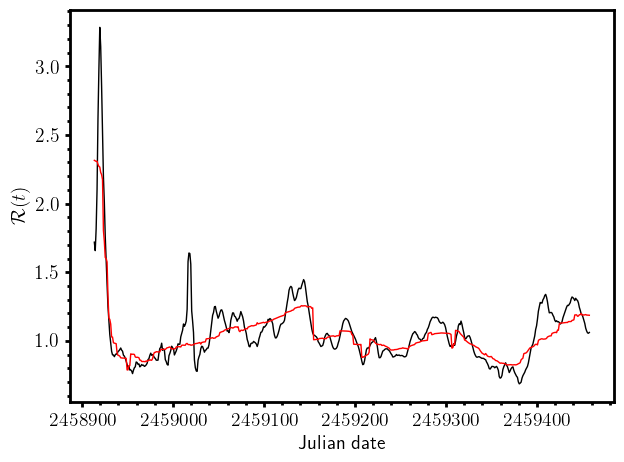

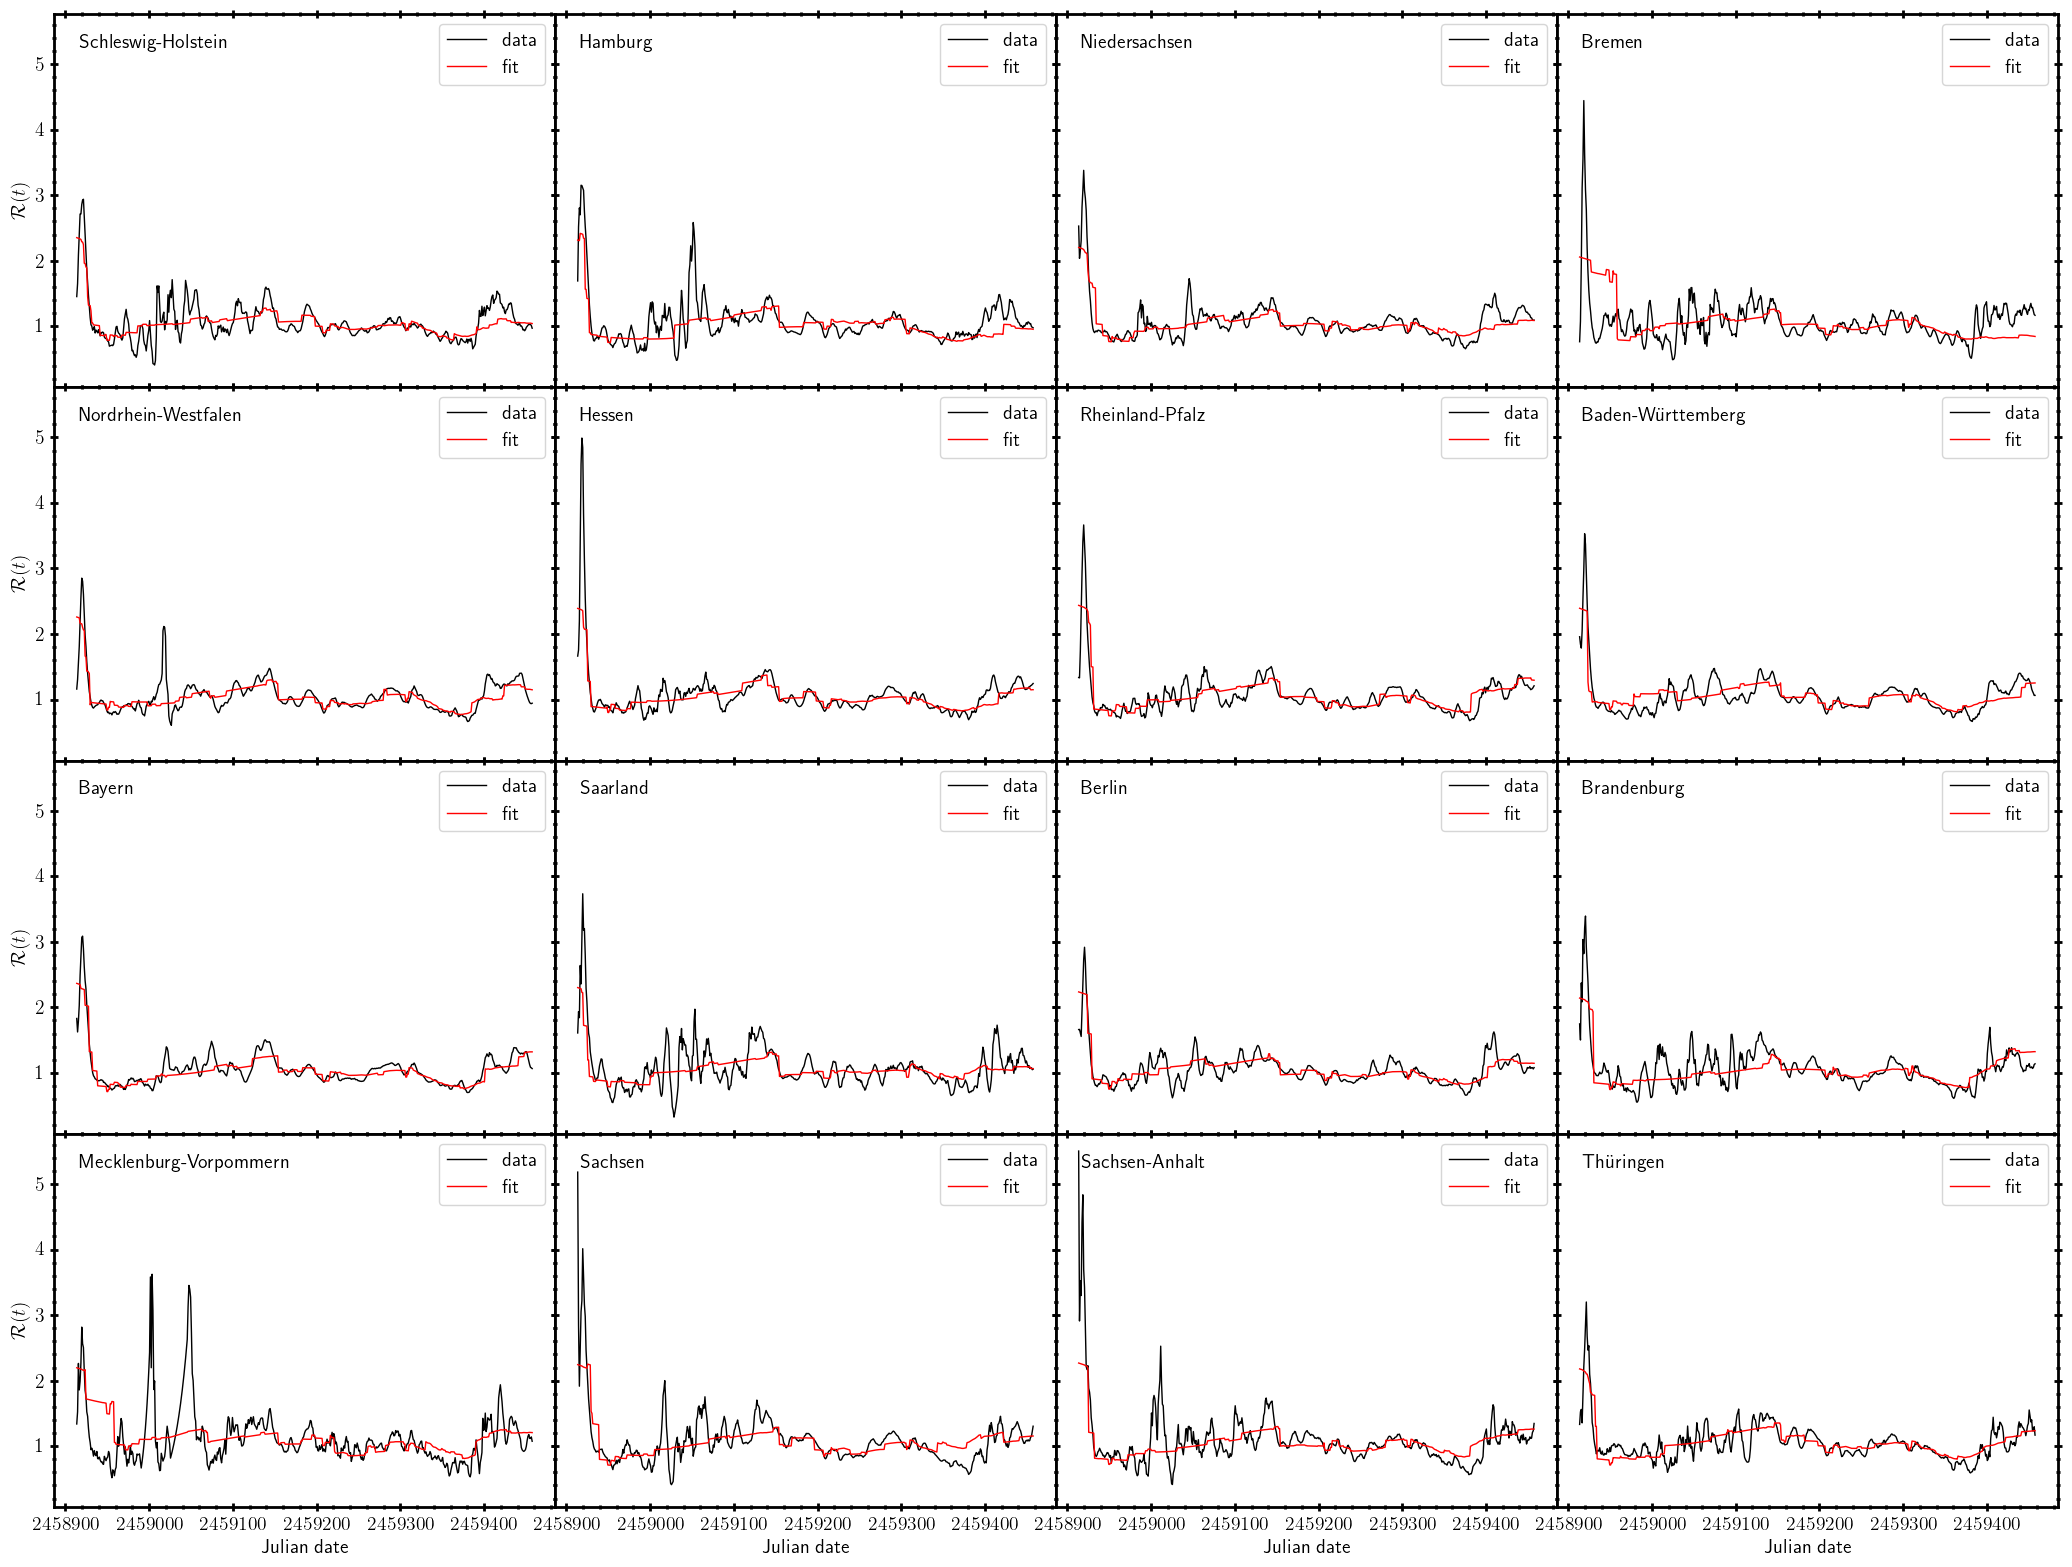

/Users/bmueller/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/Users/bmueller/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


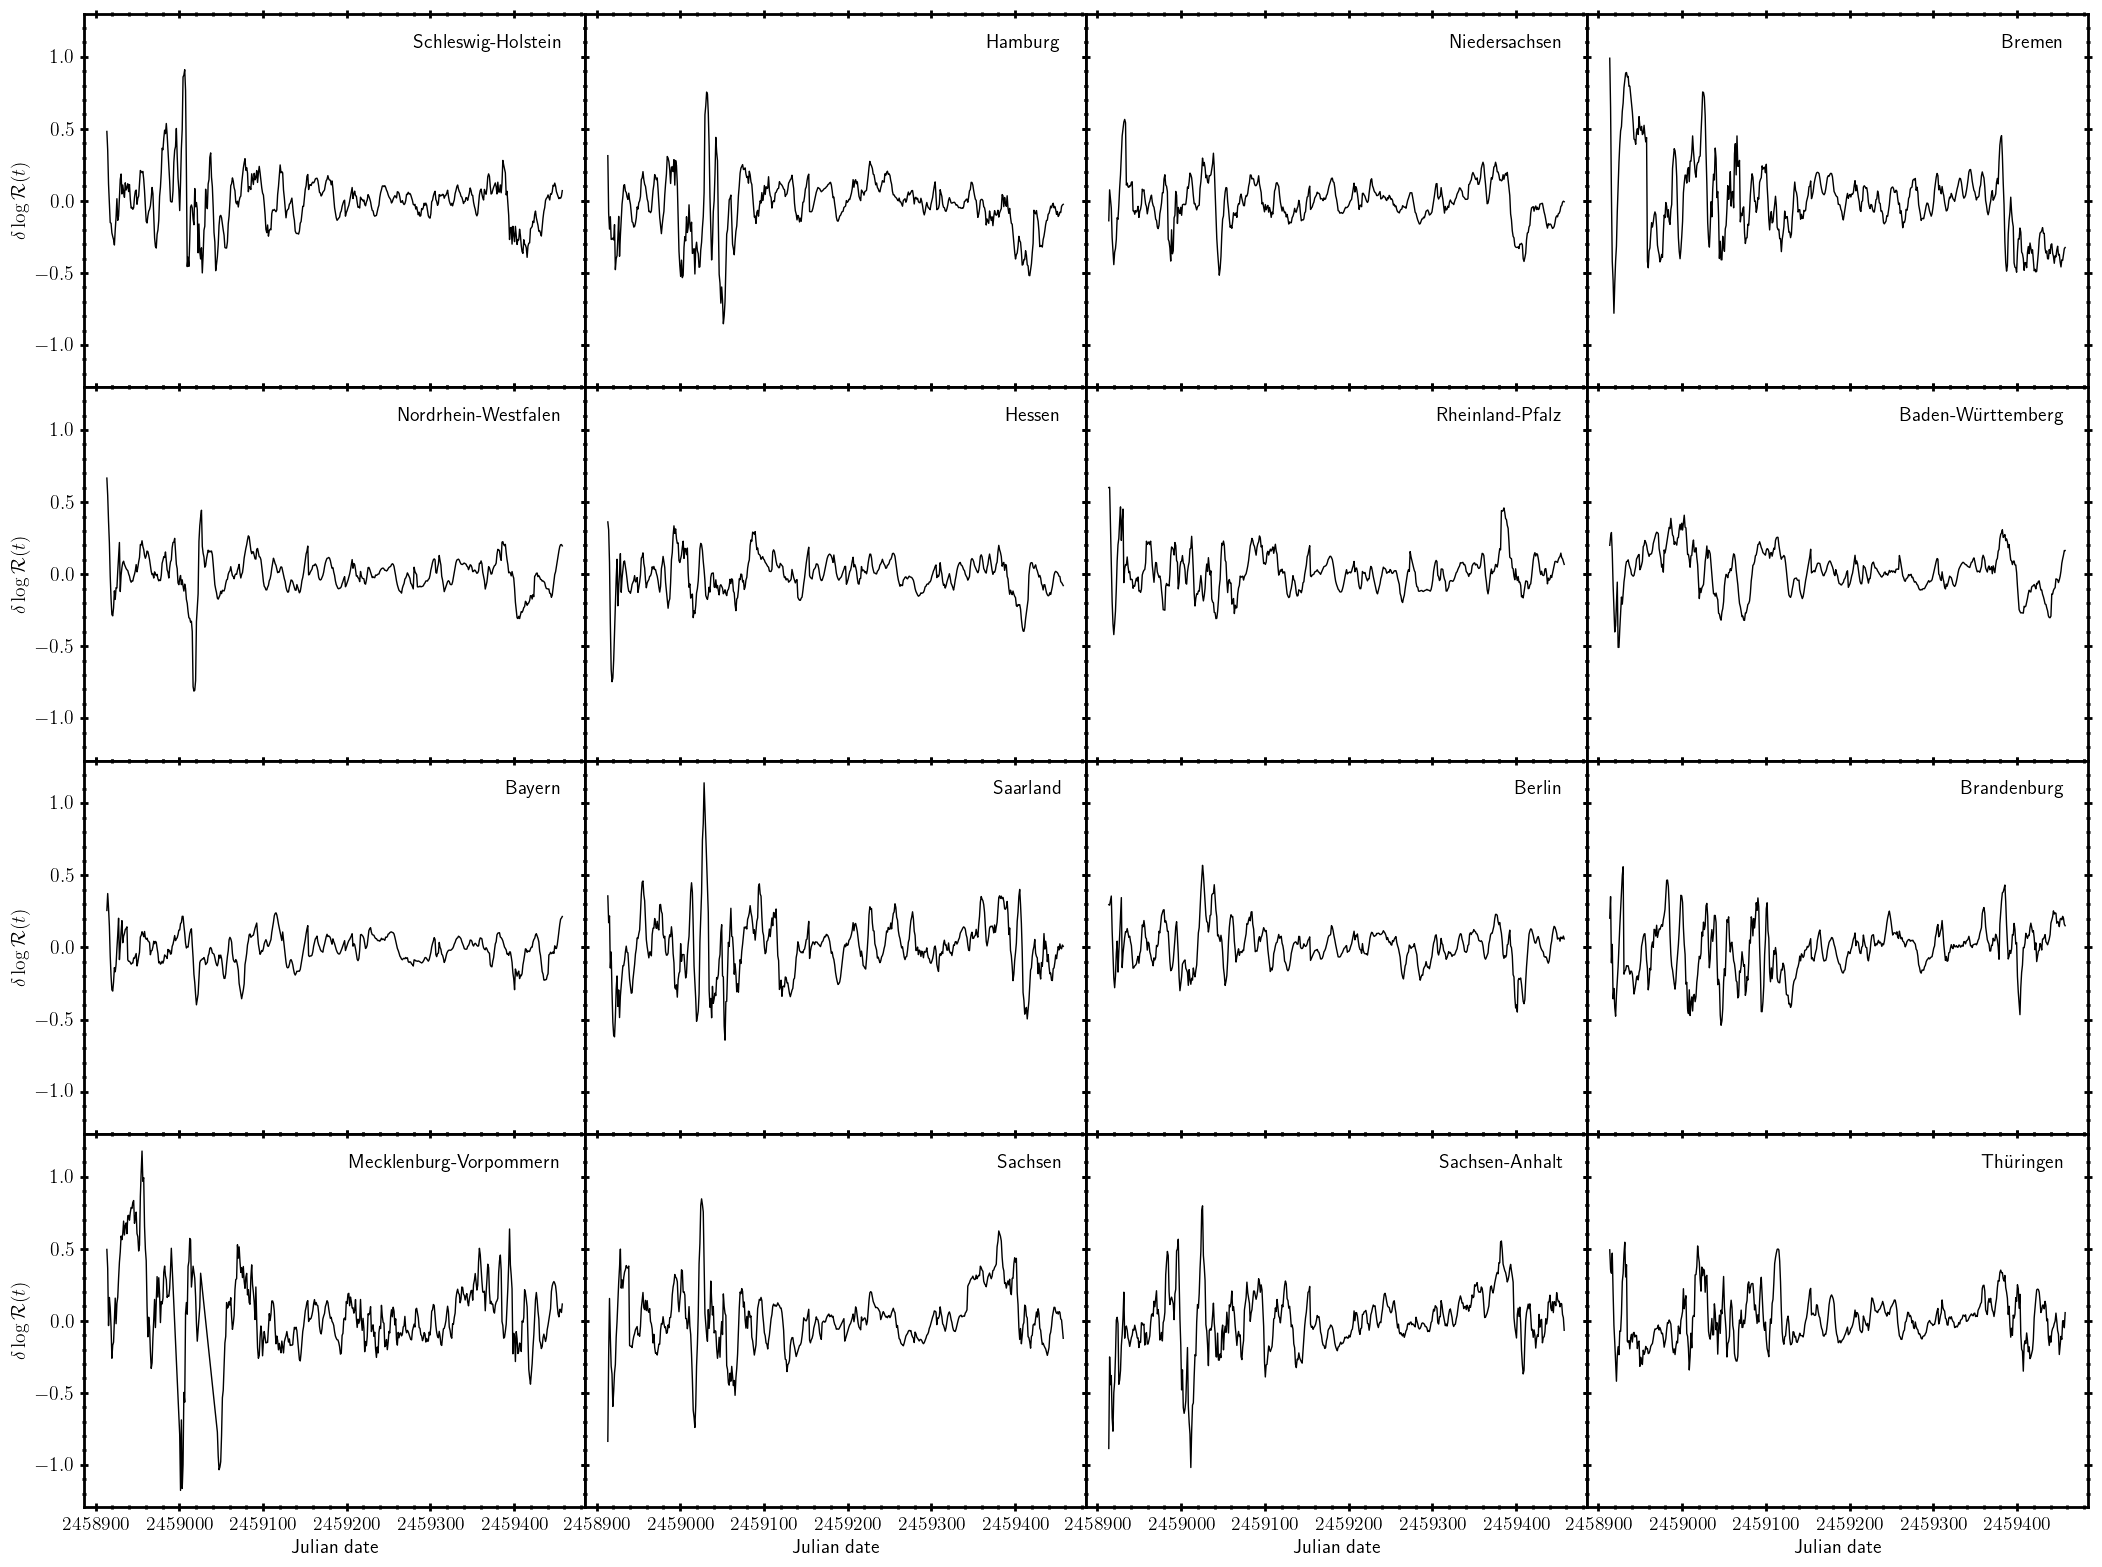

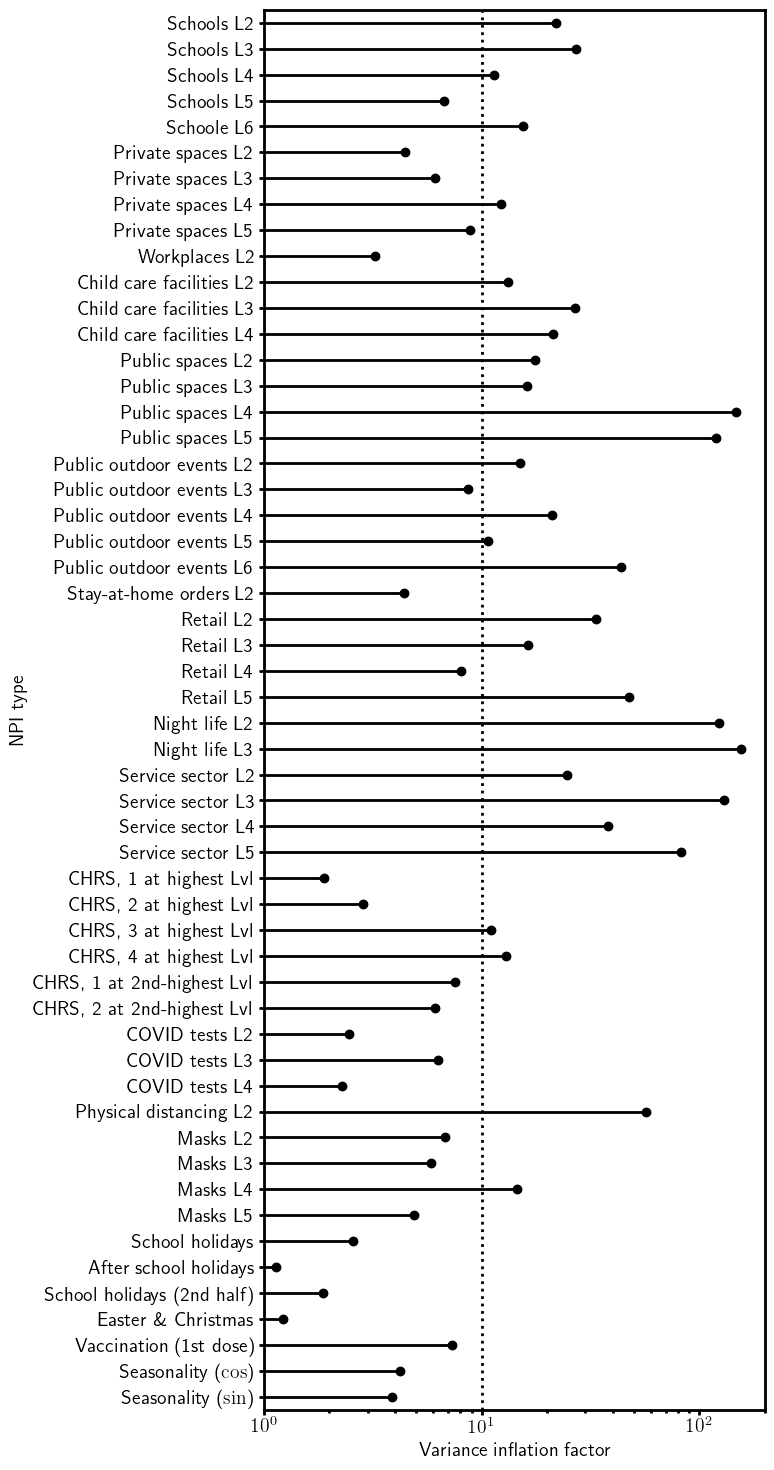

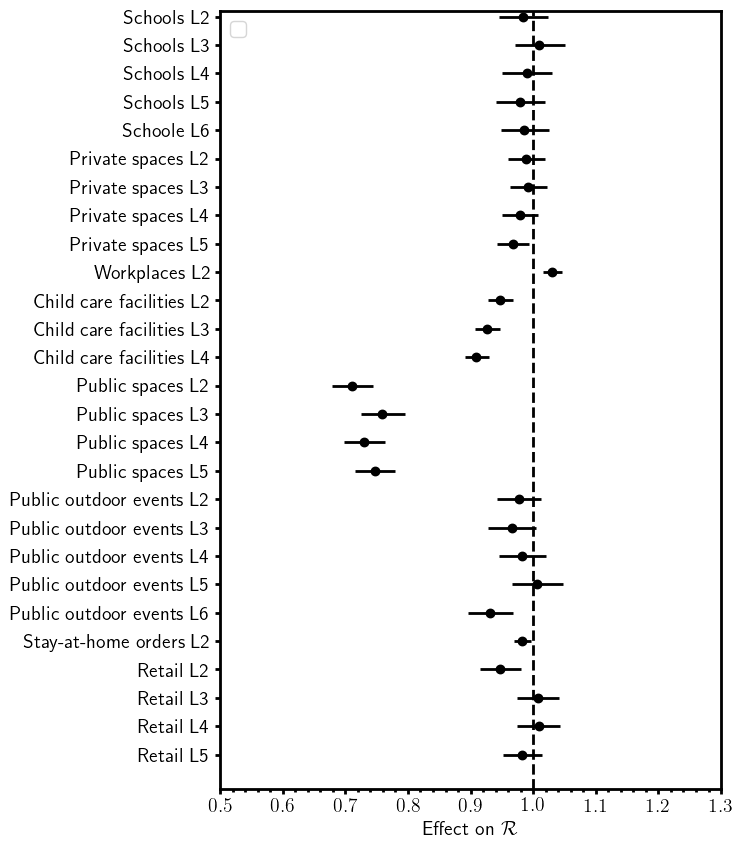

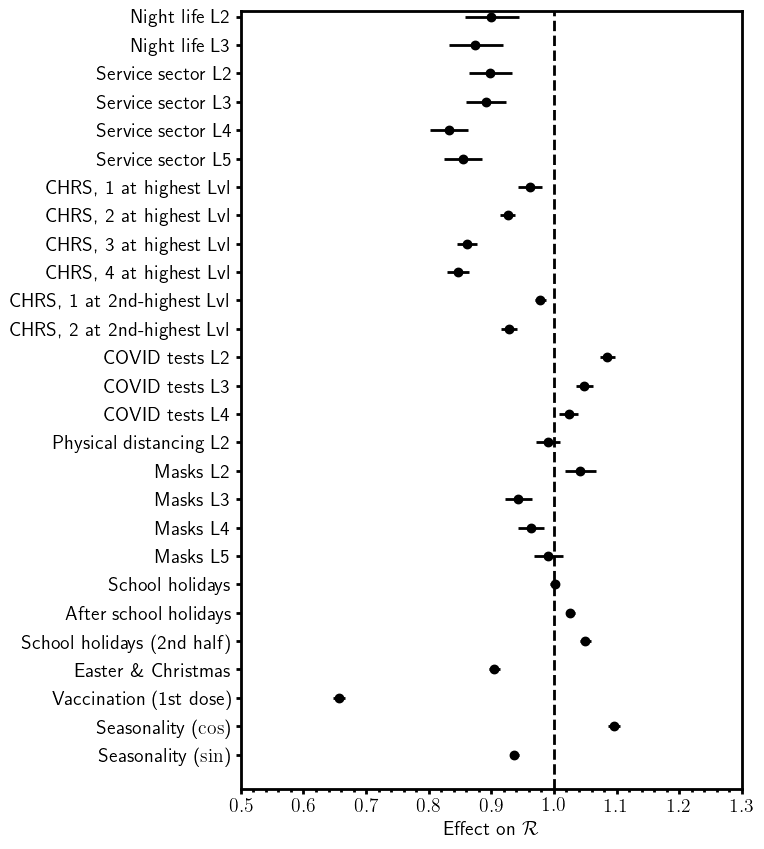

In [5]:
# Baseline model with standard regression errors
model_baseline = sm.WLS (np.reshape(y,[nb*nt]), np.reshape(x,[nb*nt,nn]),\
                   weights=np.reshape(wt,[nb*nt]))
res_baseline = model_baseline.fit()

print ("Durbin-Watson statistic for all states:", \
       durbin_watson (np.reshape (res_baseline.resid,(nb,nt)), axis=1))

# Create plots for the baseline model

# i)   Fit vs. data by state
# ii)  Fit vs. data (averaged) for the entire country
# iii) Residuals by state
aux_plot.plot_fit (res_baseline, y, wt, date, keys_state, alpha=alpha, delta=delta)

# iv) Variance inflation factors
aux_plot.plot_vif (x, nn-nb, keys_nice)

aux_plot.plot_results_split([res_baseline],\
                      keys=keys_nice[0:nn-nb],\
                      nnpi=nn-nb, xlim=(0.5,1.3),\
                      xticks=np.arange(0.5,1.31,0.1), tag='baseline')

In [6]:
# Linear regression with Driscoll-Kraay errors
model_dk = sm.WLS (np.reshape(y,[nb*nt]), np.reshape(x,[nb*nt,nn]),\
                   weights=np.reshape(wt,[nb*nt]))
# Standard formula for lags
maxlags = int(4.*(nt/100)**(2./9.))
res_dk = model_dk.fit(cov_type='hac-groupsum',\
                      cov_kwds = {'time' : np.repeat(date.astype(int),nb),\
                                  'maxlags' : maxlags})

# Linear regression with Driscoll-Kraay errors, test for long-range correlations
# Allow a maximum lag of 90 days to check whether there is any difference
model_dk90 = sm.WLS (np.reshape(y,[nb*nt]), np.reshape(x,[nb*nt,nn]),\
                   weights=np.reshape(wt,[nb*nt]))
res_dk90 = model_dk90.fit(cov_type='hac-groupsum',\
                      cov_kwds = {'time' : np.repeat(date.astype(int),nb),\
                                  'maxlags' : 90})

In [7]:
# Linear regression, error bars based on Ebisuzaki's method
res_ebisuzaki = lr_ebisuzaki .model(x, y, wt)

WLS regression, confidence intervals based on Ebisuzaki's method.


In [8]:
# Linear regression with stationary bootstrap errors
res_bt = lr_bootstrap.model (x, y, wt,nboot=500)

WLS regression, confidence intervals based on stationary bootstrap.
Average block length not specified, using length of 20.
Boostrapping, resampling 500 times.


100%|█████████████████████████████████████████| 500/500 [00:16<00:00, 29.60it/s]


In [9]:
# Two-way fixed effects (entity and time) combined with hierarchical inference of seasonality effects
res_2wfe = lr_2wfe.model (x, y, wt, nboot = 500)

Average block length not specified, using length of 14.


100%|█████████████████████████████████████████| 500/500 [09:34<00:00,  1.15s/it]


In [10]:
# Regression models with ARMA (p,q) errors.
# Please be aware that this runs very slowly on Google Colab!

res_arma_1_11 = lr_arma.model(x, y, wt, keys_x, p=1, q=11).fit(maxiter=120)

#fh = open (path+'/'+'arma_1_11.pickle','wb')
#pickle.dump (res_arma_1_11, fh)
#fh.close()

#fh = open (path+'/'+'arma_1_11.pickle','rb')
#res_arma_1_11 = pickle.load (fh)
#fh.close()

# Run a grid of models with ARMA (p,q) errors to select lags, e.g.,
# based on BIC (or convergence of parameters and error bars).

#arma_grid = lr_arma.arma_grid (x, y, wt, keys_x, p_max=7, q_max=13, maxiter=100)

In [11]:
# WARNING: The dynamical model may be too expensive to run on Google Colab.

model_dyn = dynamical_model.model(x, wt, y, wt, 0.3*alpha+0.6*delta,keys_x, \
                            nboot=100, maxiter_base=150, maxiter_boot=30)

#fh = open (path+'/'+'model_dyn.pickle','wb')
#pickle.dump (model_dyn, fh)
#fh.close()

#fh = open (path+'/'+'model_dyn.pickle','rb')
#model_dyn = pickle.load (fh)
#fh.close()

/Users/bmueller/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/Users/bmueller/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


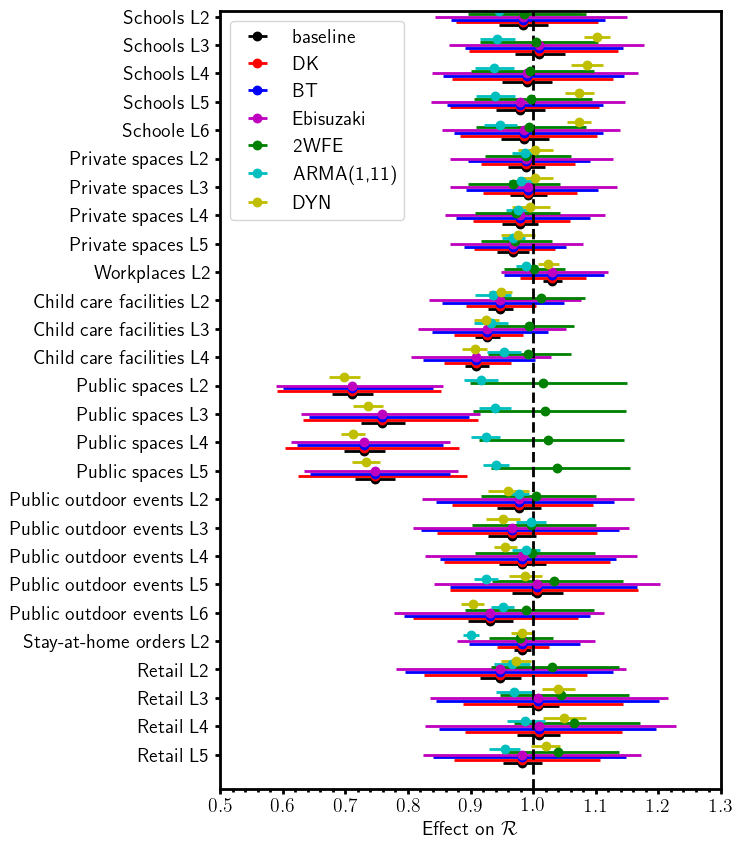

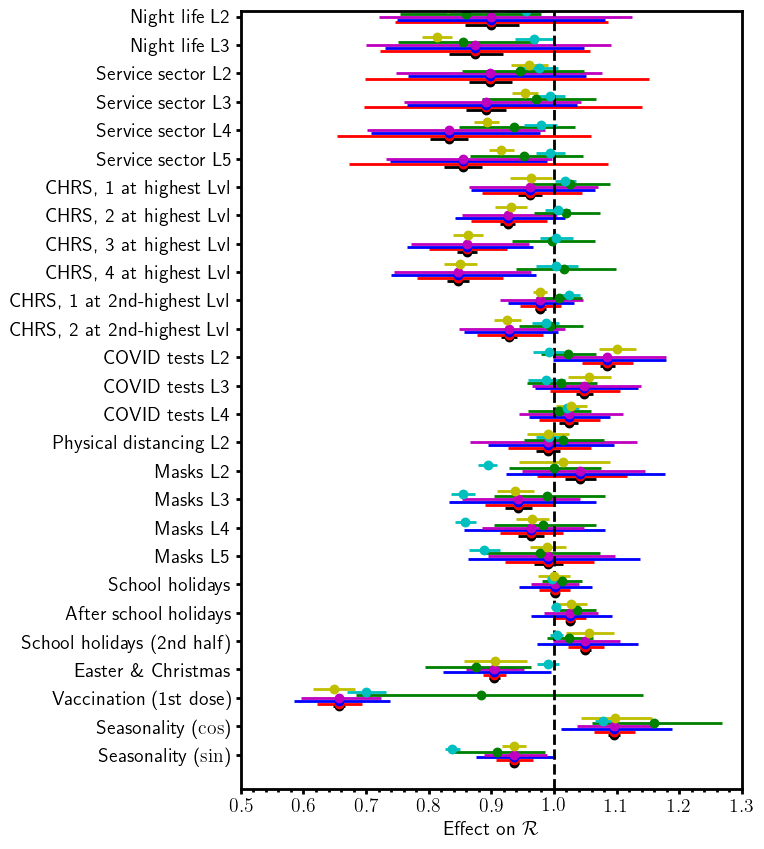

In [12]:
aux_plot.plot_results_split([res_baseline, res_dk, res_bt,\
                             res_ebisuzaki, res_2wfe, res_arma_1_11,\
                             model_dyn],\
                      labels=['baseline','DK','BT','Ebisuzaki',\
                              '2WFE','ARMA(1,11)','DYN'],\
                      keys=keys_nice[0:nn-nb],\
                      nnpi=nn-nb, xlim=(0.5,1.3),\
                      xticks=np.arange(0.5,1.31,0.1), tag='set_a',\
                      colors = ['k','r','b','m','g','c','y'])

Rank the models

In [13]:
rank_effects.rank_effects([res_dk,res_ebisuzaki,\
                           res_bt,res_arma_1_11,model_dyn,res_2wfe],\
                           keys_nice, nn-nb, dof=nb*nt-nn,\
                           cut1=4, cut2=0.15, latex_out=True)

Seasonality ($\cos$) & 0 & 0 & 0 \\
Vaccination (1st dose) & 0 & 1 & 1 \\
Easter \& Christmas & 0 & 1 & 1 \\
Seasonality ($\sin$) & 0 & 1 & 1 \\
Public spaces L2 & 1 & 1 & 2 \\
Public spaces L4 & 1 & 1 & 2 \\
Public spaces L5 & 1 & 1 & 2 \\
Public spaces L3 & 1 & 1 & 2 \\
Service sector L4 & 0 & 3 & 3 \\
Service sector L5 & 0 & 3 & 3 \\
Night life L2 & 0 & 3 & 3 \\
Child care facilities L4 & 0 & 3 & 3 \\
Child care facilities L3 & 0 & 3 & 3 \\
Masks L3 & 0 & 3 & 3 \\
CHRS, 3 at highest Lvl & 1 & 2 & 3 \\
Night life L3 & 0 & 4 & 4 \\
CHRS, 2 at 2nd-highest Lvl & 0 & 4 & 4 \\
Public outdoor events L6 & 0 & 4 & 4 \\
Masks L4 & 0 & 4 & 4 \\
Stay-at-home orders L2 & 0 & 4 & 4 \\
CHRS, 4 at highest Lvl & 2 & 2 & 4 \\


Seasonality ($\cos$) & 0.002 \\
Seasonality ($\sin$) & 0.008 \\
Easter \& Christmas & 0.028 \\
Vaccination (1st dose) & 0.029 \\
Service sector L4 & 0.041 \\
Night life L3 & 0.052 \\
Night life L2 & 0.077 \\
Child care facilities L4 & 0.082 \\
Public spaces L2 & 0.100 \\
CHRS,

Group B

In [14]:
# Random forest regression
# This can take considerable time. When running on Google Colab, I recommend
# a small number of bootstrap samples, e.g., 50, and skipping cross-validation
# by specifying the hyperparameters.

# Version RF1
# Effect sizes based actual NPI activation pattern as reference
# WARNING: Despite random seed selection, behaviour may not be completely
# deterministic.
res_rf1 = rf_model.rf_results(x[:,:,:-nb], y, wt, nboot=100,\
                            max_depth=13, max_features=4,
                            n_estimators=100, ref_state=1)

#fh = open (path+'/'+'rf1.pickle','wb')
#pickle.dump (res_rf1, fh)
#fh.close()

# Version RF0
# Effect sizes based on no-NPI state as reference (seasonality only)
res_rf0 = rf_model.rf_results(x[:,:,:-nb], y, wt, nboot=100,\
                            max_depth=13, max_features=4,
                            n_estimators=100, ref_state=0)

#fh = open (path+'/'+'rf0.pickle','wb')
#pickle.dump (res_rf0, fh)
#fh.close()

#fh = open (path+'/'+'rf1.pickle','rb')
#res_rf1 = pickle.load (fh)
#fh.close()

#fh = open (path+'/'+'rf0.pickle','rb')
#res_rf0 = pickle.load (fh)
#fh.close()

In [15]:
# Elastic Net with cross-validation
res_elastic = lr_elastic_net.model (x, y, wt, nboot=500)
# Principal component (truncated SVD) regression
res_pcr = pc_regression.model (x, y, wt, nboot=500)

Elastic net regression
Hyperparameter selection using cross validation
Confidence intervals based on stationary bootstrap
Optimal values from cross-validation:
alpha = 0.007499
l1_ratio = 0.002000
Average block length not specified, using length of 21.
Boostrapping, resampling 500 times.


500it [00:19, 25.11it/s]


Principal component regression
Confidence intervals based on stationary bootstrap
Hyperparameter selection using cross-validation
Detemining optimal number of components by cross-validation...
2 compomnents: CV score = 120.398828
3 compomnents: CV score = 109.829249
4 compomnents: CV score = 121.179192
5 compomnents: CV score = 122.591429
6 compomnents: CV score = 117.614249
7 compomnents: CV score = 147.060511
8 compomnents: CV score = 130.015125
9 compomnents: CV score = 129.629957
10 compomnents: CV score = 132.940250
11 compomnents: CV score = 119.701386
12 compomnents: CV score = 93.441900
13 compomnents: CV score = 92.817643
14 compomnents: CV score = 101.506597
15 compomnents: CV score = 96.970069
16 compomnents: CV score = 101.006648
17 compomnents: CV score = 97.159875
18 compomnents: CV score = 100.487149
19 compomnents: CV score = 101.344052
Optimal number of compponents: 13
Average block length not specified, using length of 25.
Boostrapping, resampling 500 times.


500it [00:06, 83.01it/s]


/Users/bmueller/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/Users/bmueller/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


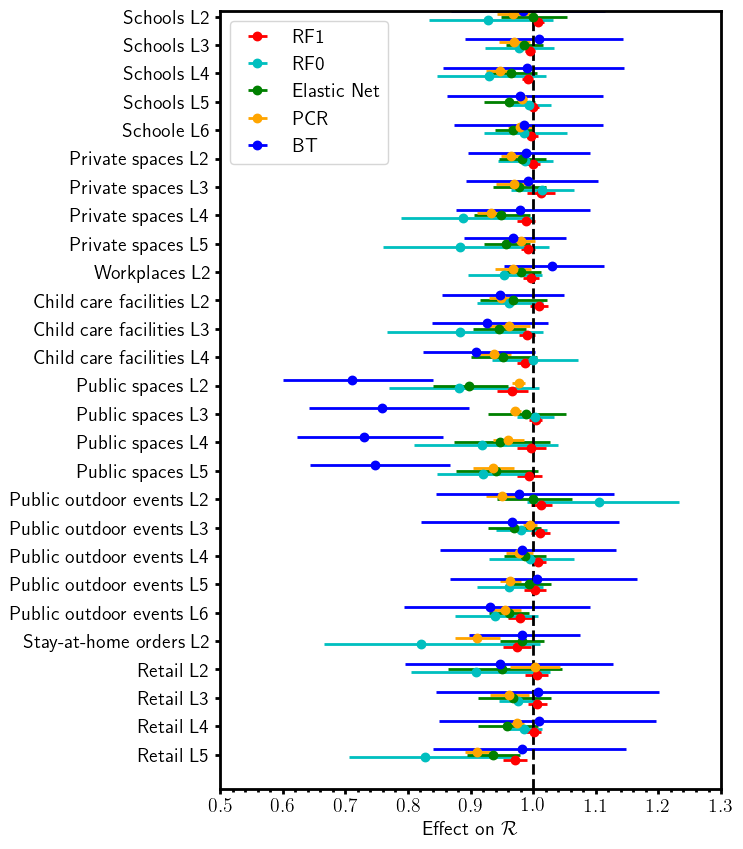

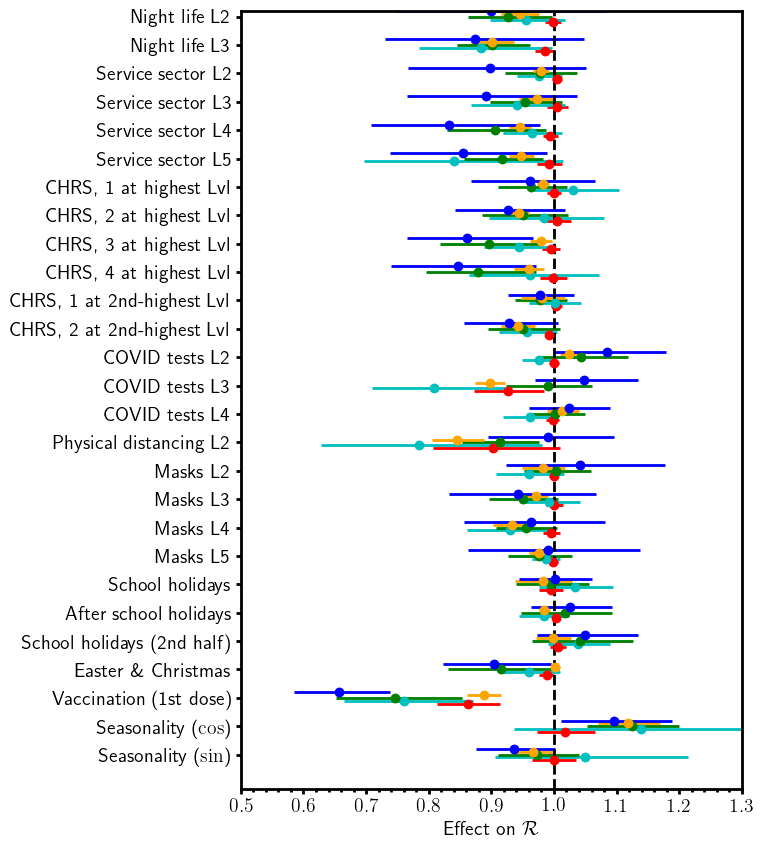

In [16]:
aux_plot.plot_results_split([res_rf1,res_rf0,res_elastic,res_pcr,res_bt,],\
                      labels=['RF1','RF0','Elastic Net','PCR','BT'],\
                      keys=keys_nice[0:nn-nb],\
                      nnpi=nn-nb, xlim=(0.5,1.3),\
                      xticks=np.arange(0.5,1.31,0.1),\
                      tag='set_b',colors=['r','c','g','orange','b'])

===============================================================================

Now test sensitivity of all models assuming that the baseline model is correct (injection-recovery test)

In [17]:
ytest = np.reshape (res_baseline.fittedvalues, (nb,nt))

In [18]:
test_baseline = sm.WLS (np.reshape(ytest,[nb*nt]),\
                        np.reshape(x,[nb*nt,nn]),\
                        weights=np.reshape(wt,[nb*nt])).fit()

In [19]:
# Linear regression with Driscoll-Kraay errors
model_dk_test = sm.WLS (np.reshape(ytest,[nb*nt]),\
                        np.reshape(x,[nb*nt,nn]),\
                        weights=np.reshape(wt,[nb*nt]))
# Standard formula for lags
maxlags = int(4.*(nt/100)**(2./9.))
test_dk = model_dk_test.fit(cov_type='hac-groupsum',\
                      cov_kwds = {'time' : np.repeat(date.astype(int),nb),\
                                  'maxlags' : maxlags})

In [20]:
# Linear regression with stationary bootstrap errors
test_bt = lr_bootstrap.model (x, ytest, wt)

WLS regression, confidence intervals based on stationary bootstrap.
Average block length not specified, using length of 36.
Boostrapping, resampling 500 times.


100%|█████████████████████████████████████████| 500/500 [00:17<00:00, 27.99it/s]


In [21]:
# Linear regression, error bars based on Ebisuzaki's method
test_ebisuzaki = lr_ebisuzaki .model(x, ytest, wt)

WLS regression, confidence intervals based on Ebisuzaki's method.


In [22]:
# Two-way fixed effects (entity and time) combined with hierarchical inference of seasonality effects
test_2wfe = lr_2wfe.model (x, ytest, wt, nboot = 500)

Average block length not specified, using length of 17.


100%|█████████████████████████████████████████| 500/500 [09:38<00:00,  1.16s/it]


In [23]:
# Regression models with ARMA (p,q) errors.
# Please be aware that this runs very slowly on Google Colab!

test_arma_1_11 = lr_arma.model(x, ytest, wt, keys_x, p=1, q=11).fit(maxiter=120)

#fh = open (path+'/'+'test_arma_1_11.pickle','wb')
#pickle.dump (test_arma_1_11, fh)
#fh.close()

#fh = open (path+'/'+'test_arma_1_11.pickle','rb')
#test_arma_1_11 = pickle.load (fh)
#fh.close()

In [24]:
# WARNING: The injection-recovery test for Model DYN involves a highly ill-conditioned problem.
# Without any noise in the data, this model converges extremely slowly unless the starting values are
# already very close to the solution.
#
# Note that 100 bootstrap samples are overkill in this case, so we reduce this to 50.

cpred = np.copy(wt)
rpred = np.exp (0.3 * alpha + 0.6 * delta + 
    np.reshape (np.dot(res_baseline.model.exog, res_baseline.params), (nb,nt)))
for i in range(nt-4):
    cpred[:,i+4] = cpred[:,i] * rpred[:,i+4]

# Slightly perturb the starting parameters
params_in = test_baseline.params + np.random.normal(scale=1e-3, size=len(test_baseline.params))
params_in = np.append (params_in, 1e-2)
# (You can perturb the parameters more strongly, but in this case you may need to restart
# the iteration to see convergence towards the correct solution. Do not attempt this unless
# you are very familiar with ill-conditioned optimisation problems.)

test_dyn = dynamical_model.model(x, cpred, ytest, cpred, 0.3*alpha+0.6*delta,keys_x,\
                                 maxiter_base=150, maxiter_boot=30,\
                                 nboot=100, params_in=params_in)

#fh = open (path+'/'+'test_dyn.pickle','wb')
#pickle.dump (test_dyn, fh)
#fh.close()

#fh = open (path+'/'+'test_dyn.pickle','rb')
#test_dyn = pickle.load (fh)
#fh.close()

/Users/bmueller/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/Users/bmueller/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


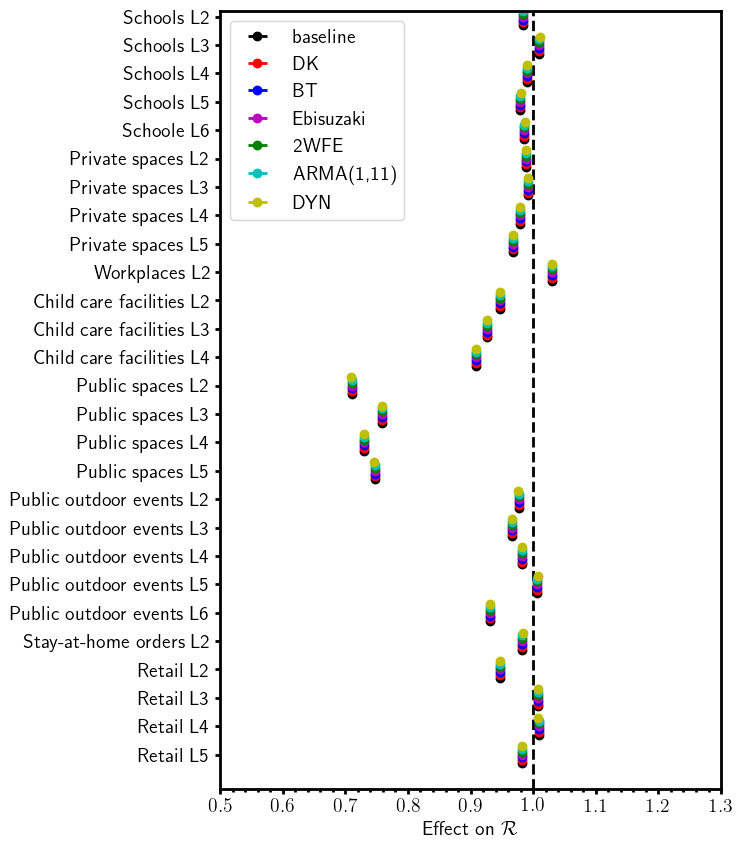

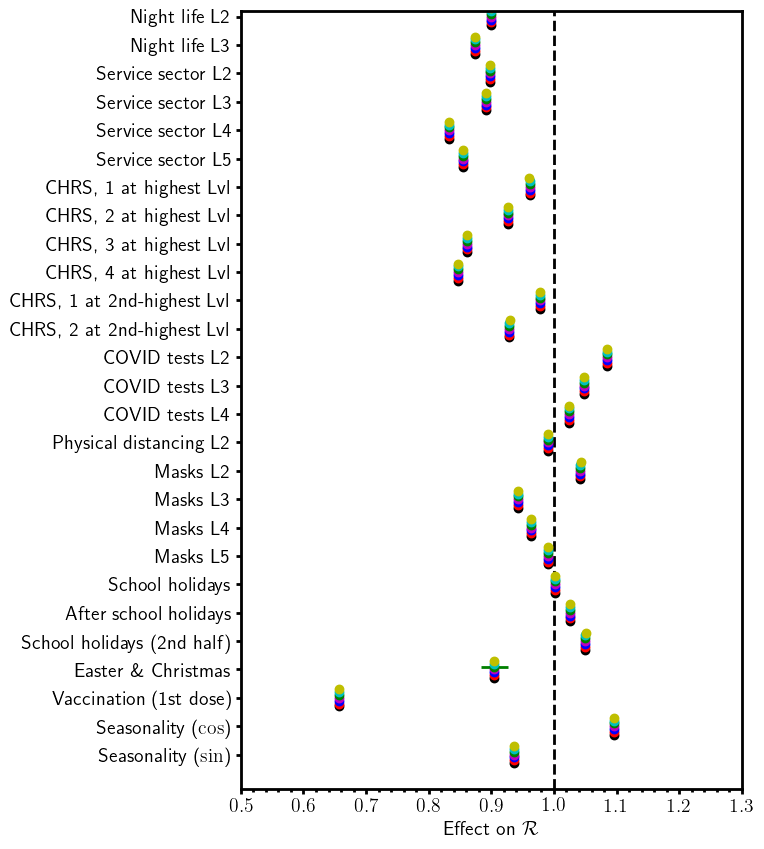

In [25]:
aux_plot.plot_results_split([test_baseline,test_dk,test_bt,test_ebisuzaki,\
                             test_2wfe, test_arma_1_11, test_dyn],\
                      labels=['baseline','DK','BT','Ebisuzaki',\
                              '2WFE','ARMA(1,11)','DYN'],\
                      keys=keys_nice[0:nn-nb],\
                      nnpi=nn-nb, xlim=(0.5,1.3),\
                      xticks=np.arange(0.5,1.31,0.1), tag='set_a_test',\
                      colors=['k','r','b','m','g','c','y'])

In [26]:
# Random forest regression
# This can take considerable time. When running on Google Colab, I recommend
# a small number of bootstrap samples, e.g., 50, and skipping cross-validation
# by specifying the hyperparameters.

# Version RF1
# Effect sizes based actual NPI activation pattern as reference
# WARNING: Despite random seed selection, behaviour may not be completely
# deterministic.
test_rf1 = rf_model.rf_results(x[:,:,:-nb], ytest, wt, nboot=100,\
                            max_depth=13, max_features=4,
                            n_estimators=100, ref_state=1)

#fh = open (path+'/'+'test_rf1.pickle','wb')
#pickle.dump (test_rf1, fh)
#fh.close()

# Version RF0
# Effect sizes based on no-NPI state as reference (seasonality only)
test_rf0 = rf_model.rf_results(x[:,:,:-nb], ytest, wt, nboot=100,\
                            max_depth=13, max_features=4,
                            n_estimators=100, ref_state=0)

#fh = open (path+'/'+'test_rf0.pickle','wb')
#pickle.dump (test_rf0, fh)
#fh.close()

#fh = open (path+'/'+'test_rf1.pickle','rb')
#test_rf1 = pickle.load (fh)
#fh.close()

#fh = open (path+'/'+'test_rf0.pickle','rb')
#test_rf0= pickle.load (fh)
#fh.close()

In [27]:
# Elastic Net with cross-validation
test_elastic = lr_elastic_net.model(x, ytest, wt, nboot=500,\
                                    alpha=res_elastic.result.alpha,\
                                    l1_ratio=res_elastic.result.l1_ratio)
# Principal component (truncated SVD) regression
test_pcr = pc_regression.model(x, ytest, wt, nboot=500, ncomp=13)

Elastic net regression
Hyperparameter selection using cross validation
Confidence intervals based on stationary bootstrap
Optimal values from cross-validation:
alpha = 0.007499
l1_ratio = 0.002000
Average block length not specified, using length of 33.
Boostrapping, resampling 500 times.


500it [00:18, 26.83it/s]


Principal component regression
Confidence intervals based on stationary bootstrap
Using 13 principal components.
Average block length not specified, using length of 36.
Boostrapping, resampling 500 times.


500it [00:05, 83.54it/s]


/Users/bmueller/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/Users/bmueller/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


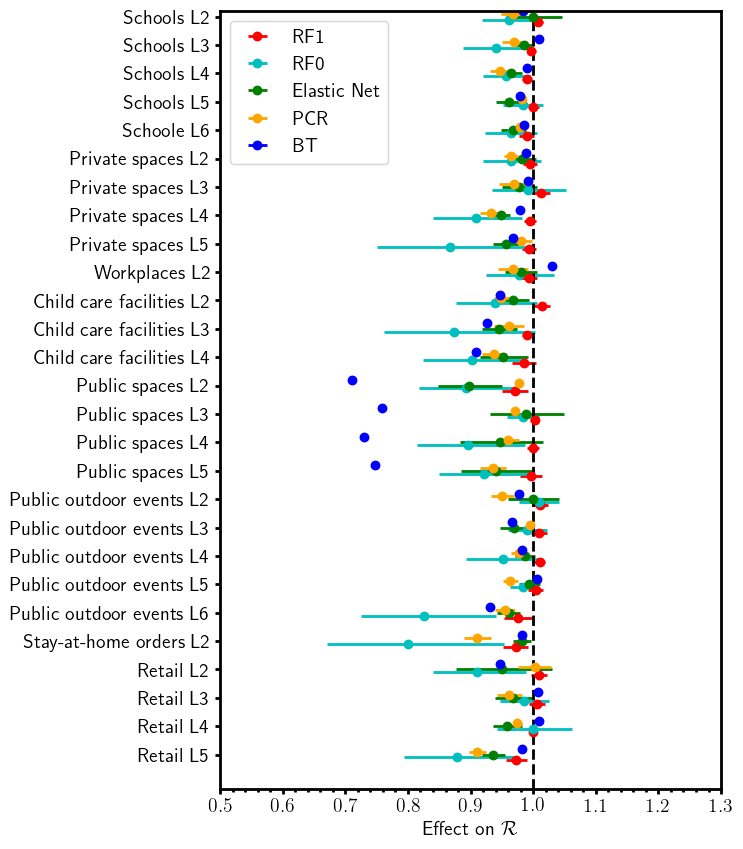

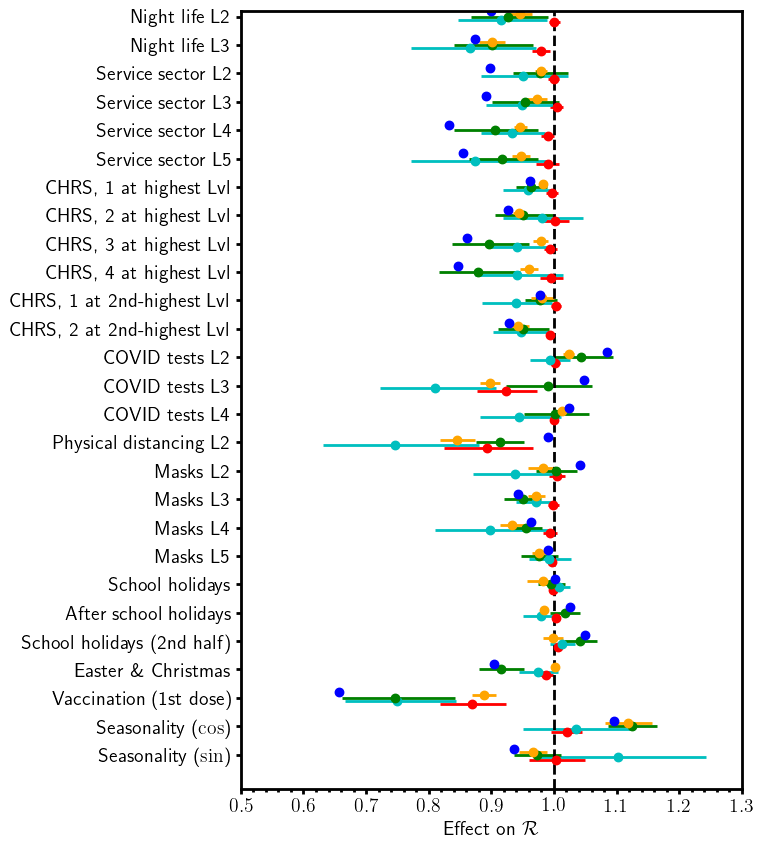

In [28]:
aux_plot.plot_results_split([test_rf1,test_rf0,\
                             test_elastic,test_pcr,test_bt],\
                      labels=['RF1','RF0','Elastic Net','PCR','BT'],\
                      keys=keys_nice[0:nn-nb],\
                      nnpi=nn-nb, xlim=(0.5,1.3),\
                      xticks=np.arange(0.5,1.31,0.1),colors=['r','c','g','orange','b'],\
                      tag='set_b_test')

Model with corrected vaccine effect

In [29]:
# Please be aware that Model VAC runs very slowly on Google Colab!

model_vac = dynamical_model.model(x, wt, y, wt,\
                                  0.3*alpha+0.6*delta, keys_x,\
                                  nboot=100, maxiter_base=250,\
                                  maxiter_boot=30, fix_vac=True)

#fh = open (path+'/'+'model_vac.pickle','wb')
#pickle.dump (model_vac, fh)
#fh.close()

#fh = open (path+'/'+'model_vac.pickle','rb')
#model_vac = pickle.load (fh)
#fh.close()

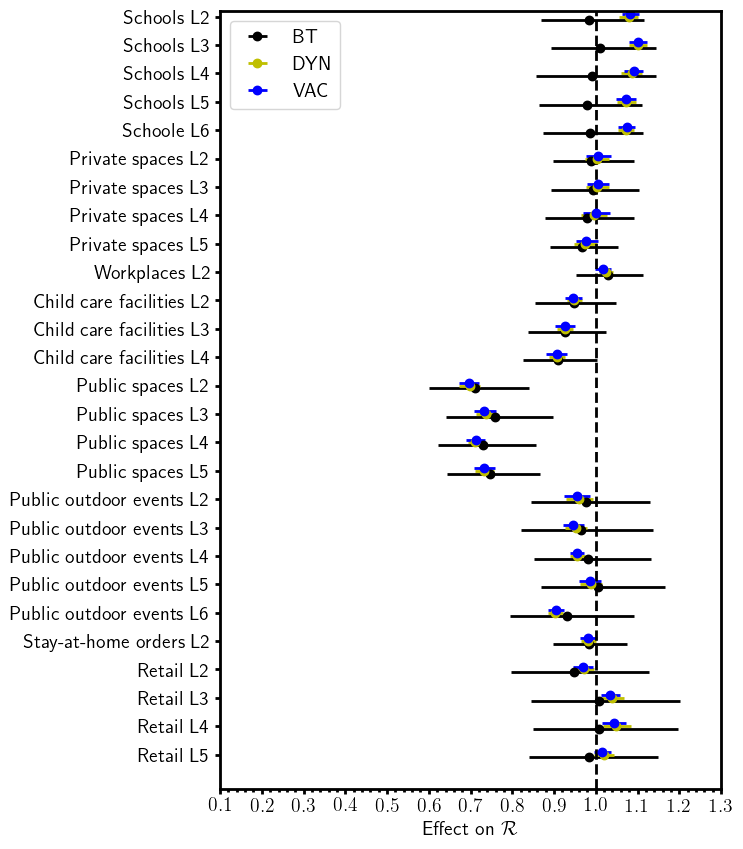

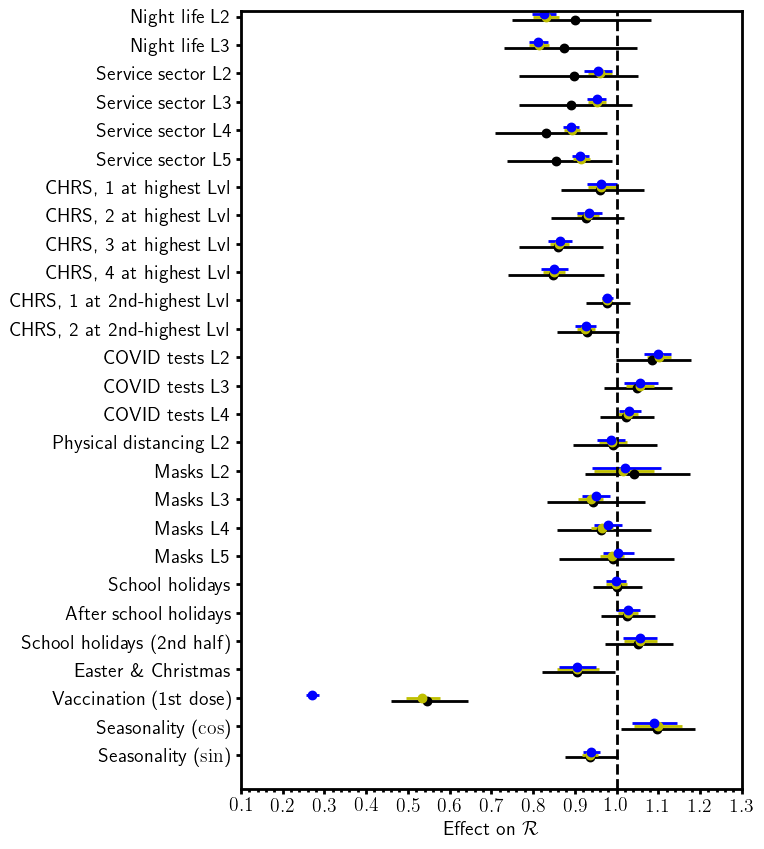

In [30]:
#fh = open (path+'/'+'model_dyn.pickle','rb')
#model_dyn = pickle.load (fh)
#fh.close()

model_dyn_cp = copy.deepcopy(model_dyn)
res_bt_cp = copy.deepcopy(res_bt)

# Rescale parameters and errors so that they correspond to 1-\eta_vac
model_dyn_cp.params[nn-nb-3] = model_dyn.params[nn-nb-3]/np.log(2)
model_dyn_cp.err[nn-nb-3] = model_dyn.err[nn-nb-3]/np.log(2)
res_bt_cp.params[nn-nb-3] = res_bt.params[nn-nb-3]/np.log(2)
res_bt_cp.err[nn-nb-3] = res_bt.err[nn-nb-3]/np.log(2)

aux_plot.plot_results_split([res_bt_cp,model_dyn_cp,model_vac],\
                      labels=['BT','DYN','VAC'],\
                      keys=keys_nice[0:nn-nb],\
                      nnpi=nn-nb, xlim=(0.1,1.3),\
                      xticks=np.arange(0.1,1.31,0.1), tag='vac_test',\
                      colors = ['k','y','blue'])

Leverage factor

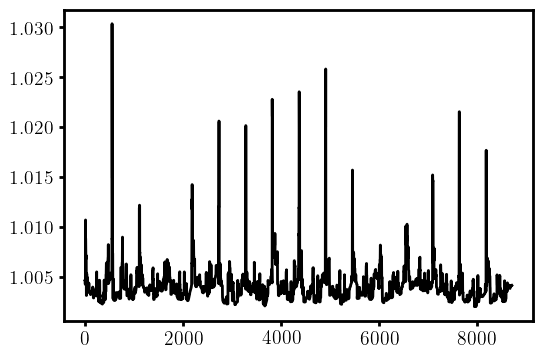

In [31]:
# Plot leverage factor
import matplotlib.pyplot as plt
xtmp = np.reshape (x,(nb*nt,nn))
hat_matrix = np.dot (xtmp,np.dot(np.linalg.inv(np.dot(np.transpose(xtmp),xtmp)),\
                               np.transpose(xtmp)))

plt.plot (1.0/np.sqrt(1.0-np.diag(hat_matrix)))

Test of different bootstrap strategies

WLS regression, confidence intervals based on stationary bootstrap.
Average block length not specified, using length of 20.
Boostrapping, resampling 500 times.


100%|█████████████████████████████████████████| 500/500 [00:17<00:00, 28.28it/s]


WLS regression, confidence intervals based on stationary bootstrap.
Average block length not specified, using length of 20.
Boostrapping, resampling 500 times.


100%|█████████████████████████████████████████| 500/500 [00:17<00:00, 27.92it/s]
/Users/bmueller/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/Users/bmueller/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


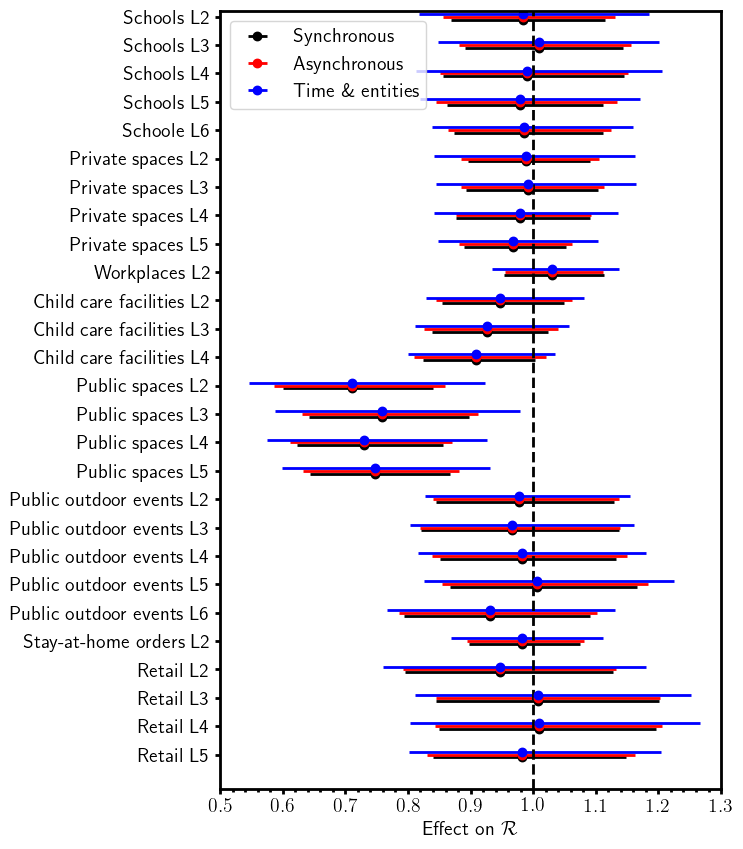

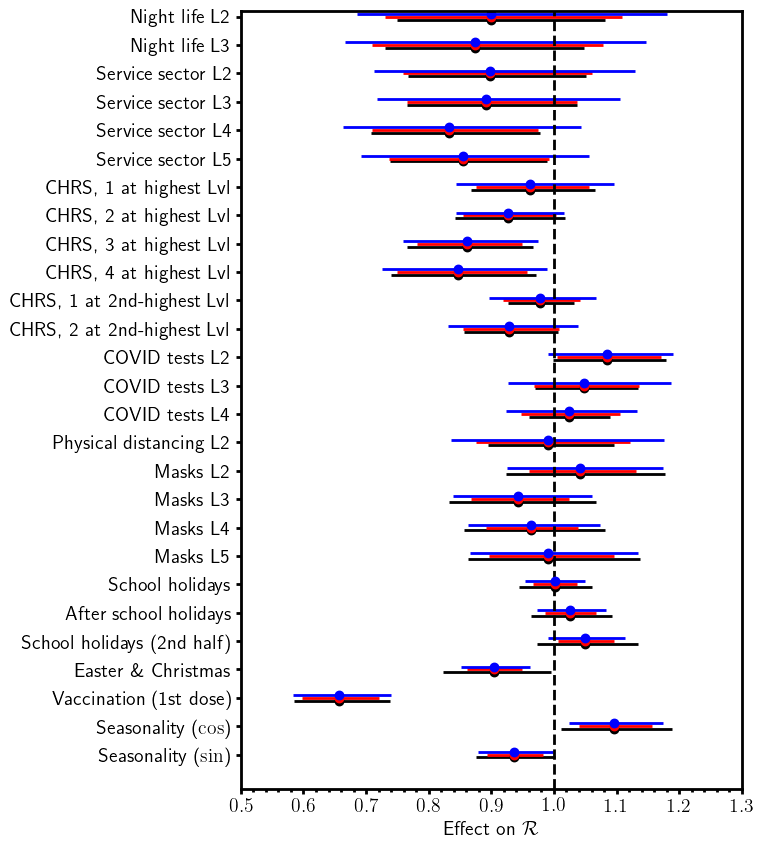

In [32]:
res_bt2 = lr_bootstrap.model (x, y, wt,nboot=500, asynchronous=True, resample_states=False)
res_bt3 = lr_bootstrap.model (x, y, wt,nboot=500, asynchronous=True, resample_states=True)

aux_plot.plot_results_split([res_bt,res_bt2,res_bt3],\
                      labels=['Synchronous','Asynchronous','Time \& entities'],\
                      keys=keys_nice[0:nn-nb],\
                      nnpi=nn-nb, xlim=(0.5,1.3),\
                      xticks=np.arange(0.5,1.31,0.1),tag='bt_test')

Fit for random forest

<Figure size 606x404 with 0 Axes>

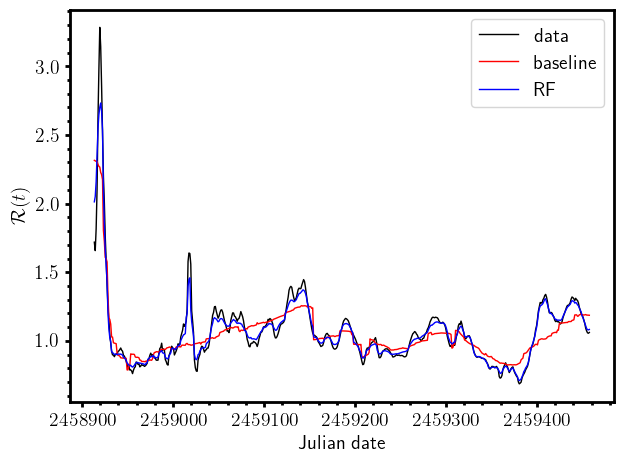

In [33]:
res_rf1.fittedvalues = res_rf1.predict
aux_plot.plot_fit_multiple ([res_baseline,res_rf1], y, wt, date, \
                            ['baseline','RF'], \
                            alpha=alpha, delta=delta, tag='comp')

Plot the effect of switching on various interventions in RF model

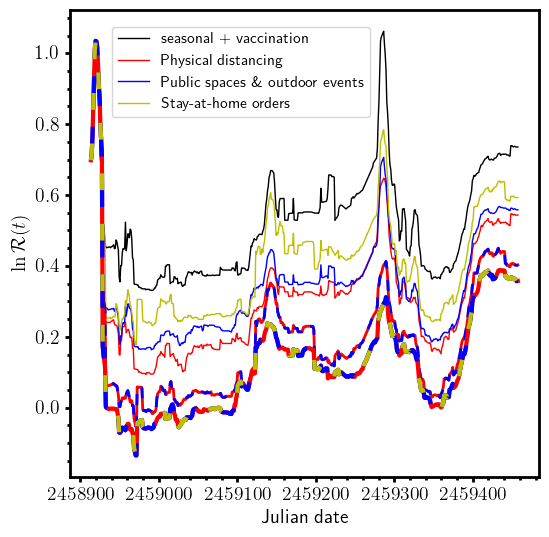

In [34]:
ib = 8 # Bavaria
x0 = np.copy(x)
x0[:,:,:47] = 0.0 # Only seasonal effects + vaccination
rpred0 = np.reshape (res_rf1.model.predict(np.reshape(x0[:,:,:-nb],(nb*nt,nn-nb))), (nb,nt))

x1a = np.copy(x0)
x1a[:,:,42] = x[:,:,42] # Add only physical distancing
rpred1a =np.reshape (res_rf1.model.predict(np.reshape(x1a[:,:,:-nb],(nb*nt,nn-nb))), (nb,nt))

x1b = np.copy(x0) # Add only restrictions in public spaces and for outdoor events
x1b[:,:,13:22] = x[:,:,13:22]
rpred1c =np.reshape (res_rf1.model.predict(np.reshape(x1b[:,:,:-nb],(nb*nt,nn-nb))), (nb,nt))

x1c = np.copy(x0)
x1c[:,:,22] = x[:,:,22] # Add only stay-at-home order
rpred1b =np.reshape (res_rf1.model.predict(np.reshape(x1c[:,:,:-nb],(nb*nt,nn-nb))), (nb,nt))

x2 = np.copy(x1a) # Physical distancing + public spaces + outdoor events
x2[:,:,13:22] = x[:,:,13:22]
rpred2 =np.reshape (res_rf1.model.predict(np.reshape(x2[:,:,:-nb],(nb*nt,nn-nb))), (nb,nt))

x3 = np.copy(x2) # Physical distancing + public spaces + outdoor events + stay-at-home
x3[:,:,22] = x[:,:,22]
rpred3 =np.reshape (res_rf1.model.predict(np.reshape(x3[:,:,:-nb],(nb*nt,nn-nb))), (nb,nt))


plt.figure(figsize=(6,6))

plt.plot(date,rpred0[ib,:]+0.3*alpha[ib,:]+0.6*delta[ib,:],linewidth=1)
plt.plot(date,rpred1a[ib,:]+0.3*alpha[ib,:]+0.6*delta[ib,:],linewidth=1,color='r')
plt.plot(date,rpred1b[ib,:]+0.3*alpha[ib,:]+0.6*delta[ib,:],linewidth=1,color='b')
plt.plot(date,rpred1c[ib,:]+0.3*alpha[ib,:]+0.6*delta[ib,:],linewidth=1,color='y')


plt.plot(date,rpred2[ib,:]+0.3*alpha[ib,:]+0.6*delta[ib,:],linewidth=2,\
         color='r')
plt.plot(date,rpred2[ib,:]+0.3*alpha[ib,:]+0.6*delta[ib,:],linewidth=2,\
         color='b',linestyle='dashed',dashes=(4,4))

plt.plot(date,rpred3[ib,:]+0.3*alpha[ib,:]+0.6*delta[ib,:],linewidth=3,\
         color='r')
plt.plot(date,rpred3[ib,:]+0.3*alpha[ib,:]+0.6*delta[ib,:],linewidth=3,\
         color='b',linestyle='dashed',dashes=(8,4))
plt.plot(date,rpred3[ib,:]+0.3*alpha[ib,:]+0.6*delta[ib,:],linewidth=3,\
         color='y',linestyle='dashed',dashes=(4,8))

#plt.plot(date,np.exp(y[ib,:]+0.3*alpha[ib,:]+0.6*delta[ib,:]))

plt.xlabel('Julian date')
plt.ylabel(r'$\ln \mathcal{R}(t)$')
plt.ticklabel_format(style = 'plain')
plt.minorticks_on()
plt.legend(['seasonal + vaccination','Physical distancing',\
            'Public spaces \& outdoor events','Stay-at-home orders'],\
           fontsize=11,loc=(0.09,0.77))
plt.savefig('rf_test_bavaria.pdf')

Feature importance for all explanatory variables

/Users/bmueller/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/Users/bmueller/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


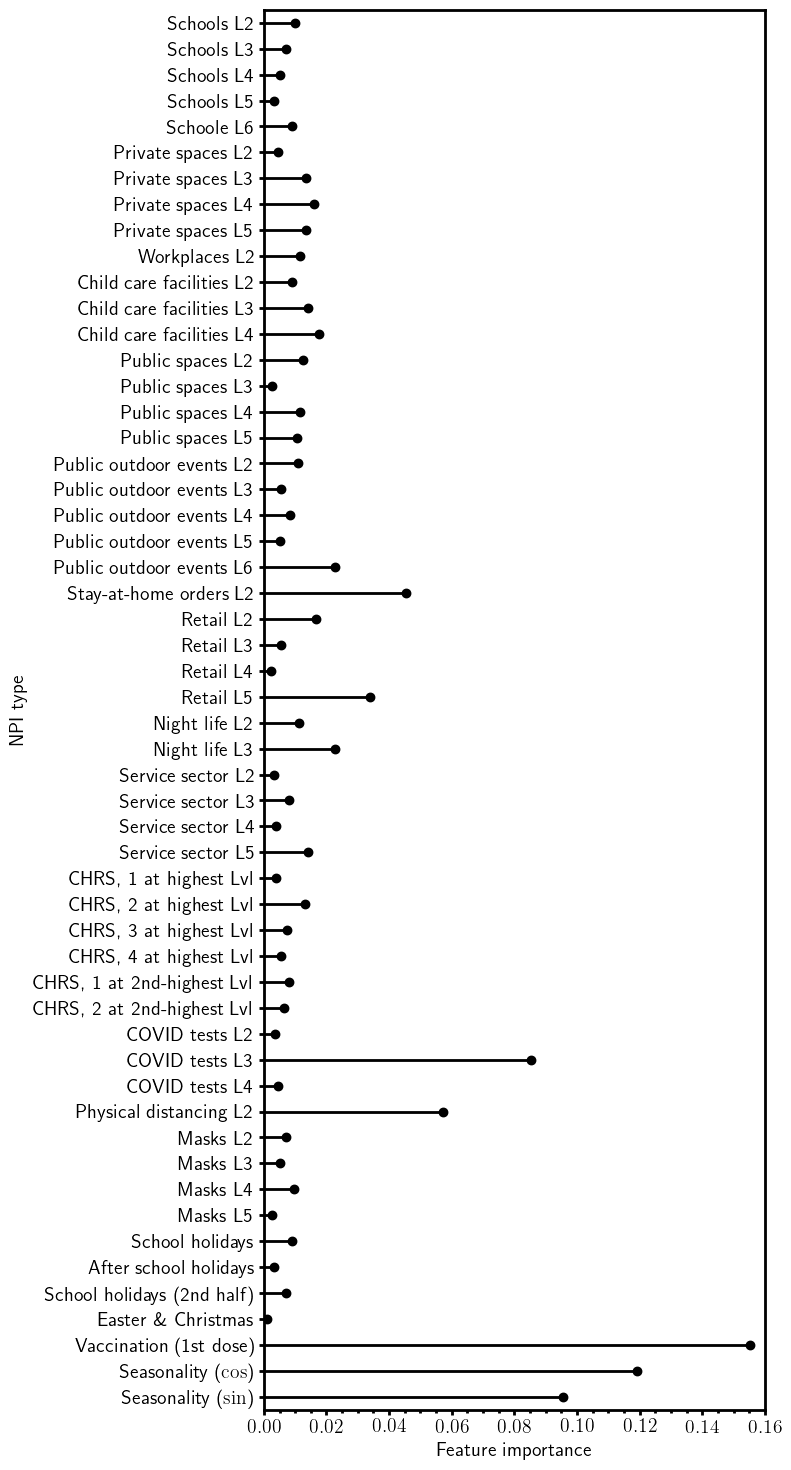

In [35]:
res_rf1.plot_importance (keys_nice)

LaTeX table of estimated effect sizes and confidence intervals

In [36]:
models = [res_dk,res_bt,res_ebisuzaki,\
          res_2wfe, res_arma_1_11,model_dyn,\
          res_rf1,res_rf0,res_elastic,res_pcr]
labels = ['DK','BT','Ebisuzaki',\
          '2WFE','ARMA(6,11)','DYN',\
          'RF1','RF0','elastic net','PCR']

print("\\begin{longtable}{" + "c" * (len(models)+1) + "}")
print("\\hline\\hline")
print("& "+ " & ".join(labels) + " \\\\")
print("\\hline")
print("\\endhead")

for i_npi in range (nn-nb):
    outstr1 = "     \\textsf{"+textwrap.wrap(keys_nice[i_npi],16)[0]+"}"
    if len(textwrap.wrap(keys_nice[i_npi],16))>1:
        outstr2 = "     \\textsf{"+textwrap.wrap(keys_nice[i_npi],16)[1]+"}"
    else:
        outstr2 = "      "
    for model in models:
        outstr1 += " & "
        if ((model.conf_int()[i_npi,1] < 0) and (model.conf_int()[i_npi,1] > -1)):
            boldstr = "\\bf"
        else:
            boldstr = ""
        if model.params[i_npi] < 0:
            color = "blue"
        else:
            color = "red"
        if i_npi>=nn-nb-2:
            color = "black"
            if model.conf_int()[i_npi,0]*model.conf_int()[i_npi,1] > 0:
                boldstr = "\\bf"
        if (model.params[i_npi] > -1) and (model.params[i_npi] < 5):
            outstr1 = outstr1 + "%s\\color{%s}%2.2f" % (boldstr, color, model.params[i_npi])
        else:
            outstr1 = outstr1 + "---"
        outstr2 += " & "
        if (model.conf_int()[i_npi,1] > -1) and (model.params[i_npi] < 5):
            outstr2 = outstr2 + "%s\\color{%s}(%2.2f,%2.2f) " % \
            (boldstr, color, model.conf_int()[i_npi,0], model.conf_int()[i_npi,1])
        else:
            outstr2 = outstr2 + "---"

    print (outstr1 + "\\\\")
    print (outstr2 + "\\\\")
    
print("\\hline\\hline")
print("\\end{longtable}")

\begin{longtable}{ccccccccccc}
\hline\hline
& DK & BT & Ebisuzaki & 2WFE & ARMA(6,11) & DYN & RF1 & RF0 & elastic net & PCR \\
\hline
\endhead
     \textsf{Schools L2} & \color{blue}-0.02 & \color{blue}-0.02 & \color{blue}-0.02 & \color{blue}-0.01 & \bf\color{blue}-0.06 & \color{red}0.08 & \color{red}0.01 & \color{blue}-0.08 & \color{red}0.00 & \bf\color{blue}-0.03\\
       & \color{blue}(-0.13,0.10)  & \color{blue}(-0.14,0.11)  & \color{blue}(-0.17,0.14)  & \color{blue}(-0.11,0.08)  & \bf\color{blue}(-0.09,-0.03)  & \color{red}(0.06,0.10)  & \color{red}(-0.00,0.02)  & \color{blue}(-0.18,0.03)  & \color{red}(-0.05,0.05)  & \bf\color{blue}(-0.06,-0.00) \\
     \textsf{Schools L3} & \color{red}0.01 & \color{red}0.01 & \color{red}0.01 & \color{red}0.00 & \bf\color{blue}-0.06 & \color{red}0.10 & \color{blue}-0.01 & \color{blue}-0.02 & \color{blue}-0.01 & \bf\color{blue}-0.03\\
       & \color{red}(-0.11,0.13)  & \color{red}(-0.11,0.13)  & \color{red}(-0.14,0.16)  & \color{red}(-0.09,0.10) 